# PEtab import and yaml2sbml

[PEtab](https://petab.readthedocs.io/en/stable/) is a format for specifying parameter estimation problems in systems biology. This notebook illustrates how the PEtab format can be used together with the ODE simulation toolbox [AMICI](https://amici.readthedocs.io/en/latest/) to define ODE based parameter estimation problems for pyABC. Then, in pyABC we can perform exact sampling based on the algorithms introduced in [this preprint](https://www.biorxiv.org/content/10.1101/2020.01.30.927004v1.abstract).

To use this functionality, you need to have (at least) PEtab and AMICI installed. Further, this notebook uses [yaml2sbml](https://yaml2sbml.readthedocs.io/en/latest/). You can install all via:

    pip install pyabc[petab,amici,yaml2sbml]

AMICI may require some [external dependencies](https://github.com/ICB-DCM/AMICI/blob/master/INSTALL.md).

In [ ]:
# install if not done yet
!pip install pyabc[petab,amici,yaml2sbml] --quiet

In [ ]:
import os
import sys

import amici
import numpy as np
from amici.importers.petab.v1 import import_petab_problem

import pyabc
import pyabc.petab

%matplotlib inline
pyabc.settings.set_figure_params('pyabc')  # for beautified plots

# folders
dir_in = 'models/'
dir_out = 'out/'
os.makedirs(dir_out, exist_ok=True)

## Generate PEtab problem from YAML

In this section, we use the tool [yaml2sbml](https://yaml2sbml.readthedocs.io/) to generate a PEtab problem based on a simple human-editable YAML file stored under `dir_in`, combining it with "measurement" data as generated in a later section. `yaml2sbml` is a simple way of manually generating models. The PEtab import below works independent of it with any valid PEtab model. We use the common conversion reaction toy model, inferring one parameter and the noise standard variation.

In [ ]:
import shutil

import petab.v1 as petab
import yaml2sbml

#  check yaml file
model_name = 'cr'
yaml_file = dir_in + model_name + '.yml'
yaml2sbml.validate_yaml(yaml_file)

The format allows to compactly define ODEs, parameters, observables and conditions:

In [3]:
with open(yaml_file) as f:
    print(f.read())

odes:
  - stateId: x1
    rightHandSide: (- theta1 * x1 + theta2 * x2)
    initialValue: 1

  - stateId: x2
    rightHandSide: (theta1 * x1 - theta2 * x2)
    initialValue: 0

parameters:
  - parameterId: theta1
    parameterName: $\theta_1$
    nominalValue: 0.08
    parameterScale: lin
    lowerBound: 0.05
    upperBound: 0.12
    estimate: 1

  - parameterId: theta2
    parameterName: $\theta_2$
    nominalValue: 0.12
    parameterScale: lin
    lowerBound: 0.05
    upperBound: 0.2
    estimate: 0

  - parameterId: sigma
    parameterName: $\sigma$
    nominalValue: 0.02
    parameterScale: log10
    lowerBound: 0.002
    upperBound: 1
    estimate: 1

observables:
  - observableId: obs_x2
    observableFormula: x2
    observableTransformation: lin
    noiseFormula: noiseParameter1_obs_x2
    noiseDistribution: normal

conditions:
  - conditionId: condition1



We combine the YAML model with "measurement" data (which can be generated as in a later section) to create a PEtab problem. This generates a stand-alone PEtab folder under `dir_out`.

In [4]:
# convert to petab
petab_dir = dir_out + model_name + '_petab/'
measurement_file = model_name + '_measurement_table.tsv'
yaml2sbml.yaml2petab(
    yaml_file,
    output_dir=petab_dir,
    sbml_name=model_name,
    petab_yaml_name='cr_petab.yml',
    measurement_table_name=measurement_file,
)

# copy measurement table over
_ = shutil.copyfile(dir_in + measurement_file, petab_dir + measurement_file)

petab_yaml_file = petab_dir + 'cr_petab.yml'
# check petab files
!petablint -v -y $petab_yaml_file

Checking SBML model...
Checking measurement table...
Checking condition table...
Checking observable table...
Checking parameter table...
PEtab format check completed successfully.


## Import PEtab problem to AMICI and pyABC

We read the PEtab problem, create an AMICI model and then import the full problem in pyABC:

In [ ]:
# read the petab problem from yaml
petab_problem = petab.Problem.from_yaml(petab_yaml_file)

# compile the petab problem to an AMICI ODE model
amici_dir = dir_out + model_name + '_amici'
if amici_dir not in sys.path:
    sys.path.insert(0, os.path.abspath(amici_dir))
model = import_petab_problem(
    petab_problem,
    model_output_dir=amici_dir,
    verbose=False,
    generate_sensitivity_code=False,
)

# the solver to numerically solve the ODE
solver = model.getSolver()

# import everything to pyABC
importer = pyabc.petab.AmiciPetabImporter(petab_problem, model, solver)

# extract what we need from the importer
prior = importer.create_prior()
model = importer.create_model()
kernel = importer.create_kernel()

Once everything has been compiled and imported, we can simply call the model. By default, this only returns the log likelihood value. If also simulated data are to be returned (and stored in the pyABC datastore), pass `return_simulations=True` to the importer. `return_rdatas` returns the full AMICI data objects including states, observables, and debugging information.

In [6]:
print(model(importer.get_nominal_parameters()))

{'llh': 22.37843729780134}


We can inspect the prior to see what parameters we infer:

In [7]:
print(prior)

<Distribution
    theta1=<RV name=uniform, args=(), kwargs={'loc': 0.05, 'scale': 0.06999999999999999}>,
    sigma=<RV name=uniform, args=(), kwargs={'loc': -2.6989700043360187, 'scale': 2.6989700043360187}>>


## Run analysis with exact inference

Now we can run an analysis using pyABC's exact sequential sampler under the assumption of measurement noise. For details on the method check the [noise assessment notebook](noise.ipynb). If instead standard distance-based ABC is to be used, the distance function must currently be manually defined from the model output. Here we use a population size of 100, usually a far large size would be preferable.

In [8]:
sampler = pyabc.MulticoreEvalParallelSampler()

temperature = pyabc.Temperature()
acceptor = pyabc.StochasticAcceptor()

abc = pyabc.ABCSMC(
    model,
    prior,
    kernel,
    eps=temperature,
    acceptor=acceptor,
    sampler=sampler,
    population_size=100,
)
# AMICI knows the data, thus we don't pass them here
abc.new(pyabc.create_sqlite_db_id(), {})
h = abc.run()

ABC.Sampler INFO: Parallelize sampling on 4 processes.
ABC.History INFO: Start <ABCSMC id=2, start_time=2021-12-07 14:17:45>
ABC INFO: Calibration sample t = -1.
ABC.Population INFO: Recording also rejected particles: True
ABC.Population INFO: Recording also rejected particles: True
ABC INFO: t: 0, eps: 1.54589326e+01.
ABC INFO: Accepted: 100 / 375 = 2.6667e-01, ESS: 9.9990e+01.
ABC INFO: t: 1, eps: 7.72946632e+00.
ABC INFO: Accepted: 100 / 439 = 2.2779e-01, ESS: 6.1330e+01.
ABC INFO: t: 2, eps: 3.86473316e+00.
ABC INFO: Accepted: 100 / 617 = 1.6207e-01, ESS: 9.1263e+01.
ABC INFO: t: 3, eps: 1.93236658e+00.
ABC INFO: Accepted: 100 / 568 = 1.7606e-01, ESS: 8.1187e+01.
ABC INFO: t: 4, eps: 1.00000000e+00.
ABC INFO: Accepted: 100 / 479 = 2.0877e-01, ESS: 9.0495e+01.
ABC INFO: Stop: Minimum epsilon.
ABC.History INFO: Done <ABCSMC id=2, duration=0:01:20.515216, end_time=2021-12-07 14:19:06>


That's it! Now we can visualize our results.

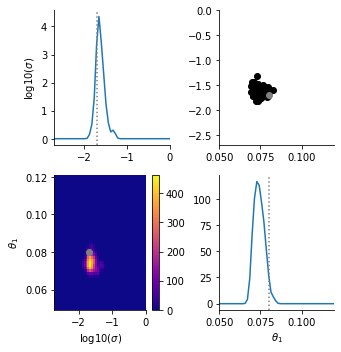

In [9]:
pyabc.visualization.plot_kde_matrix_highlevel(
    h,
    limits=importer.get_bounds(),
    refval=importer.get_nominal_parameters(),
    refval_color='grey',
    names=importer.get_parameter_names(),
);

## Generate data

This section needs only be run if one wants to generate new synthetic data:

In [10]:
# Change this line to run the code
if False:
    import importlib
    import sys

    import amici
    import amici.petab_import
    import pandas as pd

    # check yaml file
    model_name = 'cr_base'
    yaml_file = dir_in + model_name + '.yml'
    yaml2sbml.validate_yaml(yaml_file)

    # convert to sbml
    sbml_file = dir_out + model_name + '.xml'
    yaml2sbml.yaml2sbml(yaml_file, sbml_file)

    # convert to amici
    amici_dir = dir_out + model_name + '_amici/'
    sbml_importer = amici.SbmlImporter(sbml_file)
    sbml_importer.sbml2amici(model_name, amici_dir)

    # import model
    if amici_dir not in sys.path:
        sys.path.insert(0, os.path.abspath(amici_dir))
    model_module = importlib.import_module(model_name)
    model = model_module.getModel()
    solver = model.getSolver()

    # measurement times
    n_time = 10
    meas_times = np.linspace(0, 10, n_time)
    model.setTimepoints(meas_times)

    # simulate with nominal parameters
    rdata = amici.runAmiciSimulation(model, solver)

    # create noisy data
    np.random.seed(2)
    sigma = 0.02
    obs_x2 = rdata['x'][:, 1] + sigma * np.random.randn(n_time)

    # to measurement dataframe
    df = pd.DataFrame(
        {
            'observableId': 'obs_x2',
            'simulationConditionId': 'condition1',
            'measurement': obs_x2,
            'time': meas_times,
            'noiseParameters': 'sigma',
        }
    )

    # store data
    df.to_csv(
        dir_in + model_name[:-5] + '_measurement_table.tsv',
        sep='\t',
        index=False,
    )